we will look at k-means clustering. We will use the algorithm to put players into different groups based on their shot creating actions. The data for this article can be found on fbref.com from Statsbomb if you would like to follow along.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#Allow for full tables to be shown
pd.options.display.max_columns = None
pd.options.display.max_rows = None

data = pd.read_csv('/content/k_means.csv',encoding='latin1')
data.head()

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld
0,Luis Abram,pe PER,DF,Granada,25.0,1996.0,6.2,3,0.48,1,0,0,2,0
1,Marcos Acuna,ar ARG,DF,Sevilla,29.0,1991.0,25.1,75,2.99,48,19,2,3,3
2,Martin Agirregabiria,es ESP,DF,AlavEs,25.0,1996.0,18.0,33,1.84,25,3,2,0,2
3,Julen Agirrezabala,es ESP,GK,Athletic Club,20.0,2000.0,4.0,1,0.25,1,0,0,0,0
4,Sergio Aguero,ar ARG,FW,Barcelona,33.0,1988.0,1.7,3,1.78,3,0,0,0,0


In [ ]:
#Split the player names by the slash, and use the first one
data['Player'] = data['Player'].str.split('\\', expand=True)[0]
#Some positions have 2 (e.g. MFFW), let's just use the first two letters for now
data['Pos'] = data['Pos'].str[:2]

One more thing to consider is the effect of playing for a stronger team. As a broad assumption, we can expect players in better teams to create more shots, and players in worse teams to produce fewer.

This might produce results that group players based on their production levels, not the styles of their productions.
Adding new columns to look at the percentages for each action type. We crated a sum column, then divided each column by the sum.

In [ ]:
#Create list of columns to sum, then assign the sum to a new column
add_list = ['PassLive', 'PassDead', 'Drib', 'Sh', 'Fld']
data['Sum SCA'] = data[add_list].sum(axis=1)

#Create our first new column
data['Pass SCA Ratio'] = data['PassLive']/data['Sum SCA']
data.head()

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio
0,Luis Abram,pe PER,DF,Granada,25.0,1996.0,6.2,3,0.48,1,0,0,2,0,3,0.333333
1,Marcos Acuna,ar ARG,DF,Sevilla,29.0,1991.0,25.1,75,2.99,48,19,2,3,3,75,0.640000
2,Martin Agirregabiria,es ESP,DF,AlavEs,25.0,1996.0,18.0,33,1.84,25,3,2,0,2,32,0.781250
3,Julen Agirrezabala,es ESP,GK,Athletic Club,20.0,2000.0,4.0,1,0.25,1,0,0,0,0,1,1.000000
4,Sergio Aguero,ar ARG,FW,Barcelona,33.0,1988.0,1.7,3,1.78,3,0,0,0,0,3,1.000000


Looking good! Scroll to the right side of the table and we can see that Martin’s shot creations were from passes nearly 78% of the time. We could manually create the remaining four, but let’s save ourselves some time and create these in a loop.

First, we’ll create the new column names in a loop. Then we will run another loop with the code that we just used to create our remaining columns.

In [ ]:
#Create new column names by adding ' ratio' to each name in our previous list
new_cols_list = [each + ' Ratio' for each in add_list]

#For each new column name, calculate the column exactly as we did a minute ago
for idx, val in enumerate(new_cols_list):
    data[val] = data[add_list[idx]]/data['Sum SCA']

#Create a sum of the percentages to check that they all add to 1
data['Sum SCA Ratio'] = data[new_cols_list].sum(axis=1)
data.head(5)

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio
0,Luis Abram,pe PER,DF,Granada,25.0,1996.0,6.2,3,0.48,1,0,0,2,0,3,0.333333,0.333333,0.000000,0.000000,0.666667,0.0000,1.0
1,Marcos Acuna,ar ARG,DF,Sevilla,29.0,1991.0,25.1,75,2.99,48,19,2,3,3,75,0.640000,0.640000,0.253333,0.026667,0.040000,0.0400,1.0
2,Martin Agirregabiria,es ESP,DF,AlavEs,25.0,1996.0,18.0,33,1.84,25,3,2,0,2,32,0.781250,0.781250,0.093750,0.062500,0.000000,0.0625,1.0
3,Julen Agirrezabala,es ESP,GK,Athletic Club,20.0,2000.0,4.0,1,0.25,1,0,0,0,0,1,1.000000,1.000000,0.000000,0.000000,0.000000,0.0000,1.0
4,Sergio Aguero,ar ARG,FW,Barcelona,33.0,1988.0,1.7,3,1.78,3,0,0,0,0,3,1.000000,1.000000,0.000000,0.000000,0.000000,0.0000,1.0


Perfect! We have loads of decimals adding to 1 that we can consider as percentages for each type of action.

One final issue to tidy… we have Julen, a GK, in the dataset. This won’t be too useful for our shot creation profiles.

We’ll create a new dataframe that will ask for only forwards or midfielders. Also, let’s set a floor for playing time & shots created to cut out anyone with low appearance/creation numbers. These numbers are arbitrary, so feel free to change them into something more useful!

In [ ]:
#New dataframe where Pos == FW or MF. AND played more than 5 90s AND created more than 15 shots
data_mffw = data[((data['Pos'] == 'FW') | (data['Pos'] == 'MF')) & (data['90s'] > 5) & (data['SCA'] > 15)]

data_mffw.head()

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio
11,Tomas Alarcon,cl CHI,MF,Cadiz,22.0,1999.0,15.8,29,1.83,14,12,1,0,0,27,0.518519,0.518519,0.444444,0.037037,0.000000,0.000000,1.0
14,Paco Alcacer,es ESP,FW,Villarreal,27.0,1993.0,8.7,16,1.83,12,0,1,2,0,15,0.800000,0.800000,0.000000,0.066667,0.133333,0.000000,1.0
15,RubEn Alcaraz,es ESP,MF,Cadiz,30.0,1991.0,12.3,39,3.18,28,5,1,2,3,39,0.717949,0.717949,0.128205,0.025641,0.051282,0.076923,1.0
17,Ivan Alejo,es ESP,MF,Cadiz,26.0,1995.0,11.8,36,3.04,31,1,3,1,0,36,0.861111,0.861111,0.027778,0.083333,0.027778,0.000000,1.0
18,Carles Alena,es ESP,MF,Getafe,23.0,1998.0,25.8,63,2.44,49,2,2,4,6,63,0.777778,0.777778,0.031746,0.031746,0.063492,0.095238,1.0


In [ ]:
km = KMeans(n_clusters=5, init='random', random_state=0)

In [ ]:
y_km = km.fit_predict(data_mffw[new_cols_list])
y_km

array([1, 4, 3, 2, 4, 0, 1, 3, 4, 0, 4, 1, 2, 0, 0, 2, 2, 3, 0, 2, 3, 0,
       2, 2, 3, 2, 4, 4, 1, 4, 2, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 4,
       3, 4, 3, 1, 2, 0, 0, 1, 4, 0, 0, 1, 0, 3, 2, 3, 0, 2, 4, 2, 2, 1,
       4, 1, 2, 0, 0, 3, 3, 2, 4, 3, 0, 2, 0, 0, 2, 1, 2, 4, 2, 4, 3, 4,
       0, 1, 1, 0, 1, 2, 2, 2, 0, 0, 4, 4, 1, 4, 2, 2, 3, 0, 2, 3, 2, 4,
       3, 0, 2, 0, 0, 2, 2, 0, 4, 2, 2, 2, 2, 4, 4, 2, 4, 0, 3, 4, 4, 0,
       2, 4, 3, 1, 3, 2, 4, 2, 1, 1, 4, 4, 4, 0, 4, 2, 2, 0, 1, 3, 1, 2,
       3, 4, 3, 3, 3, 3, 4, 0, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 1, 0, 0, 0,
       3, 4, 0, 1, 3], dtype=int32)

In [ ]:
data_mffw['Cluster'] = y_km
data_mffw.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
11,Tomas Alarcon,cl CHI,MF,Cadiz,22.0,1999.0,15.8,29,1.83,14,12,1,0,0,27,0.518519,0.518519,0.444444,0.037037,0.000000,0.000000,1.0,1
14,Paco Alcacer,es ESP,FW,Villarreal,27.0,1993.0,8.7,16,1.83,12,0,1,2,0,15,0.800000,0.800000,0.000000,0.066667,0.133333,0.000000,1.0,4
15,RubEn Alcaraz,es ESP,MF,Cadiz,30.0,1991.0,12.3,39,3.18,28,5,1,2,3,39,0.717949,0.717949,0.128205,0.025641,0.051282,0.076923,1.0,3
17,Ivan Alejo,es ESP,MF,Cadiz,26.0,1995.0,11.8,36,3.04,31,1,3,1,0,36,0.861111,0.861111,0.027778,0.083333,0.027778,0.000000,1.0,2
18,Carles Alena,es ESP,MF,Getafe,23.0,1998.0,25.8,63,2.44,49,2,2,4,6,63,0.777778,0.777778,0.031746,0.031746,0.063492,0.095238,1.0,4


In [ ]:
data_mffw[data_mffw['Cluster'] == 0].head()

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
24,Amath,sn SEN,FW,Mallorca,25.0,1996.0,9.8,24,2.44,11,1,2,4,4,22,0.500000,0.500000,0.045455,0.090909,0.181818,0.181818,1.0,0
42,Ezequiel avila,ar ARG,FW,Osasuna,27.0,1994.0,20.8,47,2.26,26,4,4,6,7,47,0.553191,0.553191,0.085106,0.085106,0.127660,0.148936,1.0,0
55,Kike Barja,es ESP,MF,Osasuna,24.0,1997.0,9.6,21,2.18,12,0,2,2,4,20,0.600000,0.600000,0.000000,0.100000,0.100000,0.200000,1.0,0
62,BebE,cv CPV,FW,Rayo Vallecano,31.0,1990.0,9.6,39,4.05,19,6,5,5,4,39,0.487179,0.487179,0.153846,0.128205,0.128205,0.102564,1.0,0
74,Lucas BoyE,ar ARG,FW,Elche,25.0,1996.0,19.0,47,2.47,29,0,8,3,3,43,0.674419,0.674419,0.000000,0.186047,0.069767,0.069767,1.0,0


Lots of set-piece takers in here, along with high pass numbers and low dribbles.

Compare it to the next cluster, which features fewer set piece takers and more creations from dribbles, shots and being fouled:

In [ ]:
data_mffw[data_mffw['Cluster'] == 1].head()

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
11,Tomas Alarcon,cl CHI,MF,Cadiz,22.0,1999.0,15.8,29,1.83,14,12,1,0,0,27,0.518519,0.518519,0.444444,0.037037,0.000000,0.000000,1.0,1
28,Mauro Arambarri,uy URU,MF,Getafe,25.0,1995.0,29.6,75,2.53,34,31,2,2,3,72,0.472222,0.472222,0.430556,0.027778,0.027778,0.041667,1.0,1
53,Enis Bardhi,mk MKD,MF,Levante,26.0,1995.0,18.9,81,4.29,43,23,2,8,5,81,0.530864,0.530864,0.283951,0.024691,0.098765,0.061728,1.0,1
101,Yannick Carrasco,be BEL,FW,AtlEtico Madrid,27.0,1993.0,28.7,122,4.25,61,26,25,6,3,121,0.504132,0.504132,0.214876,0.206612,0.049587,0.024793,1.0,1
141,Memphis Depay,nl NED,FW,Barcelona,27.0,1994.0,20.6,81,3.94,44,20,9,3,5,81,0.543210,0.543210,0.246914,0.111111,0.037037,0.061728,1.0,1


In [ ]:
#We'll do this a couple of times, let's make a function
def plotClusters(xAxis, yAxis):
    plt.scatter(data_mffw[data_mffw['Cluster']==0][xAxis], data_mffw[data_mffw['Cluster']==0][yAxis], s=40, c='red', label ='Cluster 1')
    plt.scatter(data_mffw[data_mffw['Cluster']==1][xAxis], data_mffw[data_mffw['Cluster']==1][yAxis], s=40, c='blue', label ='Cluster 2')
    plt.scatter(data_mffw[data_mffw['Cluster']==2][xAxis], data_mffw[data_mffw['Cluster']==2][yAxis], s=40, c='green', label ='Cluster 3')
    plt.scatter(data_mffw[data_mffw['Cluster']==3][xAxis], data_mffw[data_mffw['Cluster']==3][yAxis], s=40, c='pink', label ='Cluster 4')
    plt.scatter(data_mffw[data_mffw['Cluster']==4][xAxis], data_mffw[data_mffw['Cluster']==4][yAxis], s=40, c='gold', label ='Cluster 5')
    plt.xlabel(xAxis)
    plt.ylabel(yAxis)    
    plt.legend() 

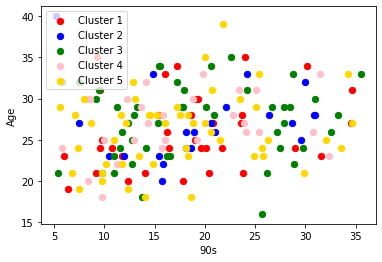

In [ ]:
#Age vs number of shot creations per 90, split by cluster
plotClusters('90s', 'Age')

In [ ]:
#Set piece takers
data_mffw[data_mffw['Cluster'] == 0]

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
24,Amath,sn SEN,FW,Mallorca,25.0,1996.0,9.8,24,2.44,11,1,2,4,4,22,0.500000,0.500000,0.045455,0.090909,0.181818,0.181818,1.0,0
42,Ezequiel avila,ar ARG,FW,Osasuna,27.0,1994.0,20.8,47,2.26,26,4,4,6,7,47,0.553191,0.553191,0.085106,0.085106,0.127660,0.148936,1.0,0
55,Kike Barja,es ESP,MF,Osasuna,24.0,1997.0,9.6,21,2.18,12,0,2,2,4,20,0.600000,0.600000,0.000000,0.100000,0.100000,0.200000,1.0,0
62,BebE,cv CPV,FW,Rayo Vallecano,31.0,1990.0,9.6,39,4.05,19,6,5,5,4,39,0.487179,0.487179,0.153846,0.128205,0.128205,0.102564,1.0,0
74,Lucas BoyE,ar ARG,FW,Elche,25.0,1996.0,19.0,47,2.47,29,0,8,3,3,43,0.674419,0.674419,0.000000,0.186047,0.069767,0.069767,1.0,0
80,Ante Budimir,hr CRO,FW,Osasuna,30.0,1991.0,19.3,28,1.45,14,0,2,4,7,27,0.518519,0.518519,0.000000,0.074074,0.148148,0.259259,1.0,0
147,Landry Dimata,be BEL,FW,Espanyol,23.0,1997.0,6.0,18,2.98,12,0,2,1,3,18,0.666667,0.666667,0.000000,0.111111,0.055556,0.166667,1.0,0
162,Hugo Duro,es ESP,FW,Valencia,21.0,1999.0,20.4,34,1.67,21,1,3,1,7,33,0.636364,0.636364,0.030303,0.090909,0.030303,0.212121,1.0,0
173,Abdessamad Ezzalzouli,ma MAR,FW,Barcelona,19.0,2001.0,6.4,17,2.64,9,0,6,1,1,17,0.529412,0.529412,0.000000,0.352941,0.058824,0.058824,1.0,0
174,Radamel Falcao,co COL,FW,Rayo Vallecano,35.0,1986.0,9.3,17,1.83,8,0,2,4,2,16,0.500000,0.500000,0.000000,0.125000,0.250000,0.125000,1.0,0


In [ ]:
#No deadballs, passes dominate but contributions from other types. Similar to group 4 who instead feature deadbslls.
data_mffw[data_mffw['Cluster'] == 1]

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
11,Tomas Alarcon,cl CHI,MF,Cadiz,22.0,1999.0,15.8,29,1.83,14,12,1,0,0,27,0.518519,0.518519,0.444444,0.037037,0.000000,0.000000,1.0,1
28,Mauro Arambarri,uy URU,MF,Getafe,25.0,1995.0,29.6,75,2.53,34,31,2,2,3,72,0.472222,0.472222,0.430556,0.027778,0.027778,0.041667,1.0,1
53,Enis Bardhi,mk MKD,MF,Levante,26.0,1995.0,18.9,81,4.29,43,23,2,8,5,81,0.530864,0.530864,0.283951,0.024691,0.098765,0.061728,1.0,1
101,Yannick Carrasco,be BEL,FW,AtlEtico Madrid,27.0,1993.0,28.7,122,4.25,61,26,25,6,3,121,0.504132,0.504132,0.214876,0.206612,0.049587,0.024793,1.0,1
141,Memphis Depay,nl NED,FW,Barcelona,27.0,1994.0,20.6,81,3.94,44,20,9,3,5,81,0.543210,0.543210,0.246914,0.111111,0.037037,0.061728,1.0,1
164,Adri Embarba,es ESP,FW,Espanyol,29.0,1992.0,22.1,92,4.17,44,26,9,5,6,90,0.488889,0.488889,0.288889,0.100000,0.055556,0.066667,1.0,1
179,Nabil Fekir,fr FRA,MF,Betis,28.0,1993.0,31.0,170,5.47,83,48,20,4,11,166,0.500000,0.500000,0.289157,0.120482,0.024096,0.066265,1.0,1
201,Manu Garcia,es ESP,MF,AlavEs,23.0,1998.0,12.0,47,3.92,26,14,3,1,2,46,0.565217,0.565217,0.304348,0.065217,0.021739,0.043478,1.0,1
203,RubEn Garcia,es ESP,MF,Osasuna,28.0,1993.0,26.4,115,4.35,62,33,5,8,1,109,0.568807,0.568807,0.302752,0.045872,0.073394,0.009174,1.0,1
237,Gerard Gumbau,es ESP,MF,Elche,26.0,1994.0,21.0,48,2.29,24,21,1,1,0,47,0.510638,0.510638,0.446809,0.021277,0.021277,0.000000,1.0,1


In [ ]:
#Passers for the most part. So we get loads of our more defensive midfielders in here. 
#Notable exceptions being some of the City players, which is pretty interesting!
data_mffw[data_mffw['Cluster'] == 2]

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
17,Ivan Alejo,es ESP,MF,Cadiz,26.0,1995.0,11.8,36,3.04,31,1,3,1,0,36,0.861111,0.861111,0.027778,0.083333,0.027778,0.000000,1.0,2
54,Keidi Bare,al ALB,MF,Espanyol,23.0,1997.0,16.5,20,1.21,18,0,1,0,1,20,0.900000,0.900000,0.000000,0.050000,0.000000,0.050000,1.0,2
64,Fran Beltran,es ESP,MF,Celta Vigo,22.0,1999.0,28.9,38,1.32,34,0,1,1,1,37,0.918919,0.918919,0.000000,0.027027,0.027027,0.027027,1.0,2
68,Karim Benzema,fr FRA,FW,Real Madrid,33.0,1987.0,28.8,130,4.52,110,0,12,7,1,130,0.846154,0.846154,0.000000,0.092308,0.053846,0.007692,1.0,2
76,Darko Brasanac,rs SRB,MF,Osasuna,29.0,1992.0,26.7,62,2.32,55,0,0,4,2,61,0.901639,0.901639,0.000000,0.000000,0.065574,0.032787,1.0,2
81,Sergio Busquets,es ESP,MF,Barcelona,33.0,1988.0,35.5,91,2.56,83,0,0,0,4,87,0.954023,0.954023,0.000000,0.000000,0.000000,0.045977,1.0,2
90,Eduardo Camavinga,fr FRA,MF,Real Madrid,18.0,2002.0,13.7,34,2.48,28,0,0,0,2,30,0.933333,0.933333,0.000000,0.000000,0.000000,0.066667,1.0,2
92,Sergio Canales,es ESP,FW,Betis,30.0,1991.0,31.0,132,4.26,114,7,5,5,1,132,0.863636,0.863636,0.053030,0.037879,0.037879,0.007576,1.0,2
104,William Carvalho,pt POR,MF,Betis,29.0,1992.0,20.1,57,2.82,50,0,4,2,0,56,0.892857,0.892857,0.000000,0.071429,0.035714,0.000000,1.0,2
105,Casemiro,br BRA,MF,Real Madrid,29.0,1992.0,28.5,68,2.38,57,0,1,2,2,62,0.919355,0.919355,0.000000,0.016129,0.032258,0.032258,1.0,2


In [ ]:
#Mostly passes, but high on dribbles & shots too
data_mffw[data_mffw['Cluster'] == 3]

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
15,RubEn Alcaraz,es ESP,MF,Cadiz,30.0,1991.0,12.3,39,3.18,28,5,1,2,3,39,0.717949,0.717949,0.128205,0.025641,0.051282,0.076923,1.0,3
37,Marco Asensio,es ESP,FW,Real Madrid,25.0,1996.0,19.2,70,3.64,42,12,5,9,2,70,0.600000,0.600000,0.171429,0.071429,0.128571,0.028571,1.0,3
70,alex Berenguer,es ESP,MF,Athletic Club,26.0,1995.0,24.1,75,3.11,47,16,4,3,4,74,0.635135,0.635135,0.216216,0.054054,0.040541,0.054054,1.0,3
79,Bryan,es ESP,MF,Valencia,20.0,2001.0,8.4,26,3.10,18,5,2,0,1,26,0.692308,0.692308,0.192308,0.076923,0.000000,0.038462,1.0,3
91,JosE Campana,es ESP,MF,Levante,28.0,1993.0,15.8,42,2.63,28,9,0,4,0,41,0.682927,0.682927,0.219512,0.000000,0.097561,0.000000,1.0,3
119,alex Collado,es ESP,MF,Granada,22.0,1999.0,11.3,36,3.18,23,6,2,2,3,36,0.638889,0.638889,0.166667,0.055556,0.055556,0.083333,1.0,3
137,Rodrigo De Paul,ar ARG,MF,AtlEtico Madrid,27.0,1994.0,23.9,95,3.97,68,21,2,1,2,94,0.723404,0.723404,0.223404,0.021277,0.010638,0.021277,1.0,3
139,Ousmane DembElE,fr FRA,FW,Barcelona,24.0,1997.0,15.7,88,5.62,60,11,10,4,3,88,0.681818,0.681818,0.125000,0.113636,0.045455,0.034091,1.0,3
183,alex Fernandez,es ESP,MF,Cadiz,28.0,1992.0,22.8,45,1.97,29,11,0,4,0,44,0.659091,0.659091,0.250000,0.000000,0.090909,0.000000,1.0,3
185,Fidel,es ESP,MF,Elche,31.0,1989.0,25.1,91,3.62,65,15,6,2,2,90,0.722222,0.722222,0.166667,0.066667,0.022222,0.022222,1.0,3


In [ ]:
#As with others, mostly passes, but the most evenly spread outside of that
#Essentially group 2 with some set pieces
data_mffw[data_mffw['Cluster'] == 4]

,Player,Nation,Pos,Squad,Age,Born,90s,SCA,SCA90,PassLive,PassDead,Drib,Sh,Fld,Sum SCA,Pass SCA Ratio,PassLive Ratio,PassDead Ratio,Drib Ratio,Sh Ratio,Fld Ratio,Sum SCA Ratio,Cluster
14,Paco Alcacer,es ESP,FW,Villarreal,27.0,1993.0,8.7,16,1.83,12,0,1,2,0,15,0.800000,0.800000,0.000000,0.066667,0.133333,0.000000,1.0,4
18,Carles Alena,es ESP,MF,Getafe,23.0,1998.0,25.8,63,2.44,49,2,2,4,6,63,0.777778,0.777778,0.031746,0.031746,0.063492,0.095238,1.0,4
38,Iago Aspas,es ESP,FW,Celta Vigo,33.0,1987.0,34.3,120,3.50,90,7,6,11,6,120,0.750000,0.750000,0.058333,0.050000,0.091667,0.050000,1.0,4
43,Iddrisu Baba,gh GHA,MF,Mallorca,25.0,1996.0,21.5,23,1.07,18,0,0,4,0,22,0.818182,0.818182,0.000000,0.000000,0.181818,0.000000,1.0,4
93,alex Cantero,es ESP,FW,Levante,21.0,2000.0,6.8,18,2.65,14,0,1,3,0,18,0.777778,0.777778,0.000000,0.055556,0.166667,0.000000,1.0,4
95,Etienne Capoue,fr FRA,MF,Villarreal,33.0,1988.0,25.4,33,1.30,21,0,5,3,1,30,0.700000,0.700000,0.000000,0.166667,0.100000,0.033333,1.0,4
102,Guido Carrillo,ar ARG,FW,Elche,30.0,1991.0,13.0,22,1.69,14,0,0,3,3,20,0.700000,0.700000,0.000000,0.000000,0.150000,0.150000,1.0,4
109,Franco Cervi,ar ARG,MF,Celta Vigo,27.0,1994.0,20.0,33,1.65,23,1,0,3,5,32,0.718750,0.718750,0.031250,0.000000,0.093750,0.156250,1.0,4
113,Samuel Chukwueze,ng NGA,MF,Villarreal,22.0,1999.0,14.8,51,3.44,37,0,10,2,2,51,0.725490,0.725490,0.000000,0.196078,0.039216,0.039216,1.0,4
116,PathE Ciss,sn SEN,MF,Rayo Vallecano,27.0,1994.0,12.2,26,2.13,16,0,0,3,2,21,0.761905,0.761905,0.000000,0.000000,0.142857,0.095238,1.0,4
